In [2]:
# Do some legitimate data preprocessing

In [3]:
import shutil
import random
import os

from tqdm import tqdm
from matplotlib import pyplot as plt

import numpy as np
from sklearn.preprocessing import StandardScaler

In [4]:
plt.rcParams["font.family"] = "Inter"

In [44]:
# Collect all features
# 10k jets takes ~2 min
n_jets = 10000

X = [None] * n_jets
y = [None] * n_jets

for i in tqdm(range(n_jets), ncols=70):
   with np.load(f"./data/jets-sample/event_{str(i).zfill(7)}.npz") as fin:
      X[i] = fin["x"]
      y[i] = fin["y"]

100%|███████████████████████████| 10000/10000 [06:41<00:00, 24.88it/s]


In [45]:
feature_labels = [
    "p_T",  # Transverse momentum
    "eta",  # eta
    "phi",  # phi
    "E",    # Energy from constituent
    "dR"    # sqrt(eta^2 + phi^2)
]
n_features = len(feature_labels)

particle_labels = [
    "Gluon",
    "Light quark",
    "W boson",
    "Z boson",
    "Top quark"
]
n_particles = len(particle_labels)

p_T 	 mean=0.0193739403039217 	 stdev=0.04301534593105316
eta 	 mean=-0.00048037400119937956 	 stdev=0.11379966139793396
phi 	 mean=-0.0735240951180458 	 stdev=0.14152520895004272
E 	 mean=0.019328080117702484 	 stdev=0.042910970747470856
dR 	 mean=0.13465869426727295 	 stdev=0.11131258308887482


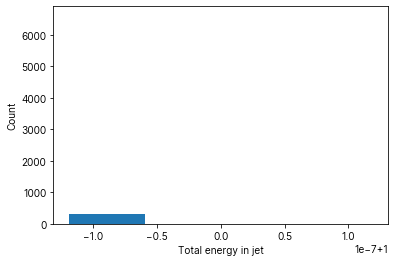

In [7]:
# Apparently everything's already normalized!
# Let's verify that
X_stack = np.vstack(X)

for i, feature in enumerate(feature_labels):
    print(f"{feature} \t mean={X_stack[:, i].mean()} \t stdev={X_stack[:, i].std()}")

plt.hist([jet[:, 3].sum() for jet in X]);
plt.xlabel("Total energy in jet")
plt.ylabel("Count");

## Graph eta, phi distributions for each particle

In [8]:
len(X)

10000

In [9]:
def jet_to_img(jet, resolution=100, bound=0.5):
    image = np.histogram2d(
        x=jet[:, 1],  # eta
        y=jet[:, 2],  # phi
        bins=resolution,
        range=[(-bound, bound)] * 2,
        weights=-np.log(jet[:, 3])  # energies
    )[0]
    image = np.log(np.maximum(image, 1))
    return image

In [46]:
resolution = 28
images = [np.zeros((resolution, resolution)) for _ in range(n_particles)]

bound = 0.6

for i in tqdm(range(n_jets), ncols=70):
    jet = X[i]
    label = np.argmax(y[i])
    
    images[label] += jet_to_img(jet, resolution, bound)


for i in range(n_particles):
    images[i] = np.maximum(images[i], 1)
    images[i] = np.log(images[i])

100%|█████████████████████████| 10000/10000 [00:01<00:00, 5263.63it/s]


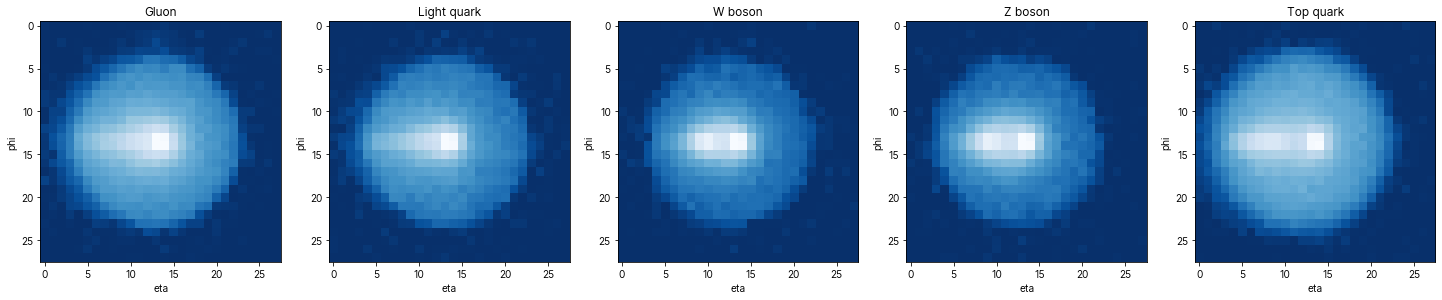

In [47]:
fig, axs = plt.subplots(1, 5, figsize=(25, 5))

for i in range(n_particles):
    axs[i].set_title(particle_labels[i])
    axs[i].set_xlabel("eta")
    axs[i].set_ylabel("phi")
    axs[i].imshow(images[i] ** 2, cmap="Blues_r")

### Plot sample jets

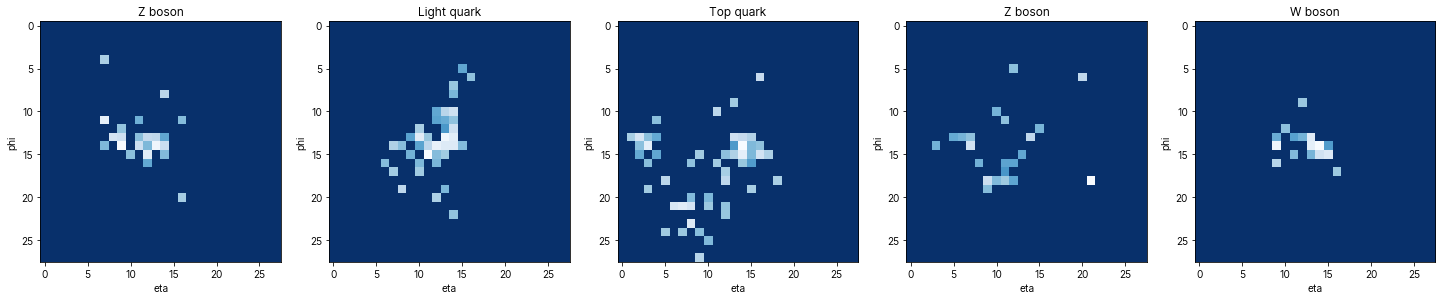

In [50]:
import random

# PLot some samples
fig, axs = plt.subplots(1, 5, figsize=(25, 5))

for i in range(5):
    idx = random.randrange(n_jets)
    label = np.argmax(y[idx]) 

    axs[i].imshow(jet_to_img(X[idx], resolution), cmap="Blues_r")
    axs[i].set_title(particle_labels[label])
    axs[i].set_xlabel("eta")
    axs[i].set_ylabel("phi")

In [51]:
# Turn images into training data
# ~3 seconds
X_new = np.zeros((n_jets, resolution, resolution))

for i in tqdm(range(n_jets)):
    jet = X[i]
    X_new[i, :, :] = jet_to_img(jet, resolution)

y_new = np.argmax(y, axis=1)

print("X_new.shape:", X_new.shape)
print("y_new.shape:", y_new.shape)

100%|██████████| 10000/10000 [00:01<00:00, 5356.29it/s]

X_new.shape: (10000, 28, 28)
y_new.shape: (10000,)


In [52]:
# Save these to a folder
# ~7 seconds
n_train = 9500
n_test = 500

save_dir = "./data/jets-10k-preprocessed"
np.save(f"{save_dir}/jets-train-features.npy", X_new[:n_train])
np.save(f"{save_dir}/jets-train-targets.npy", y_new[:n_train])

np.save(f"{save_dir}/jets-test-features.npy", X_new[n_train:(n_train + n_test)])
np.save(f"{save_dir}/jets-test-targets.npy", y_new[n_train:(n_train + n_test)])

### Fun, unrelated graphic

(-0.5, 0.5)

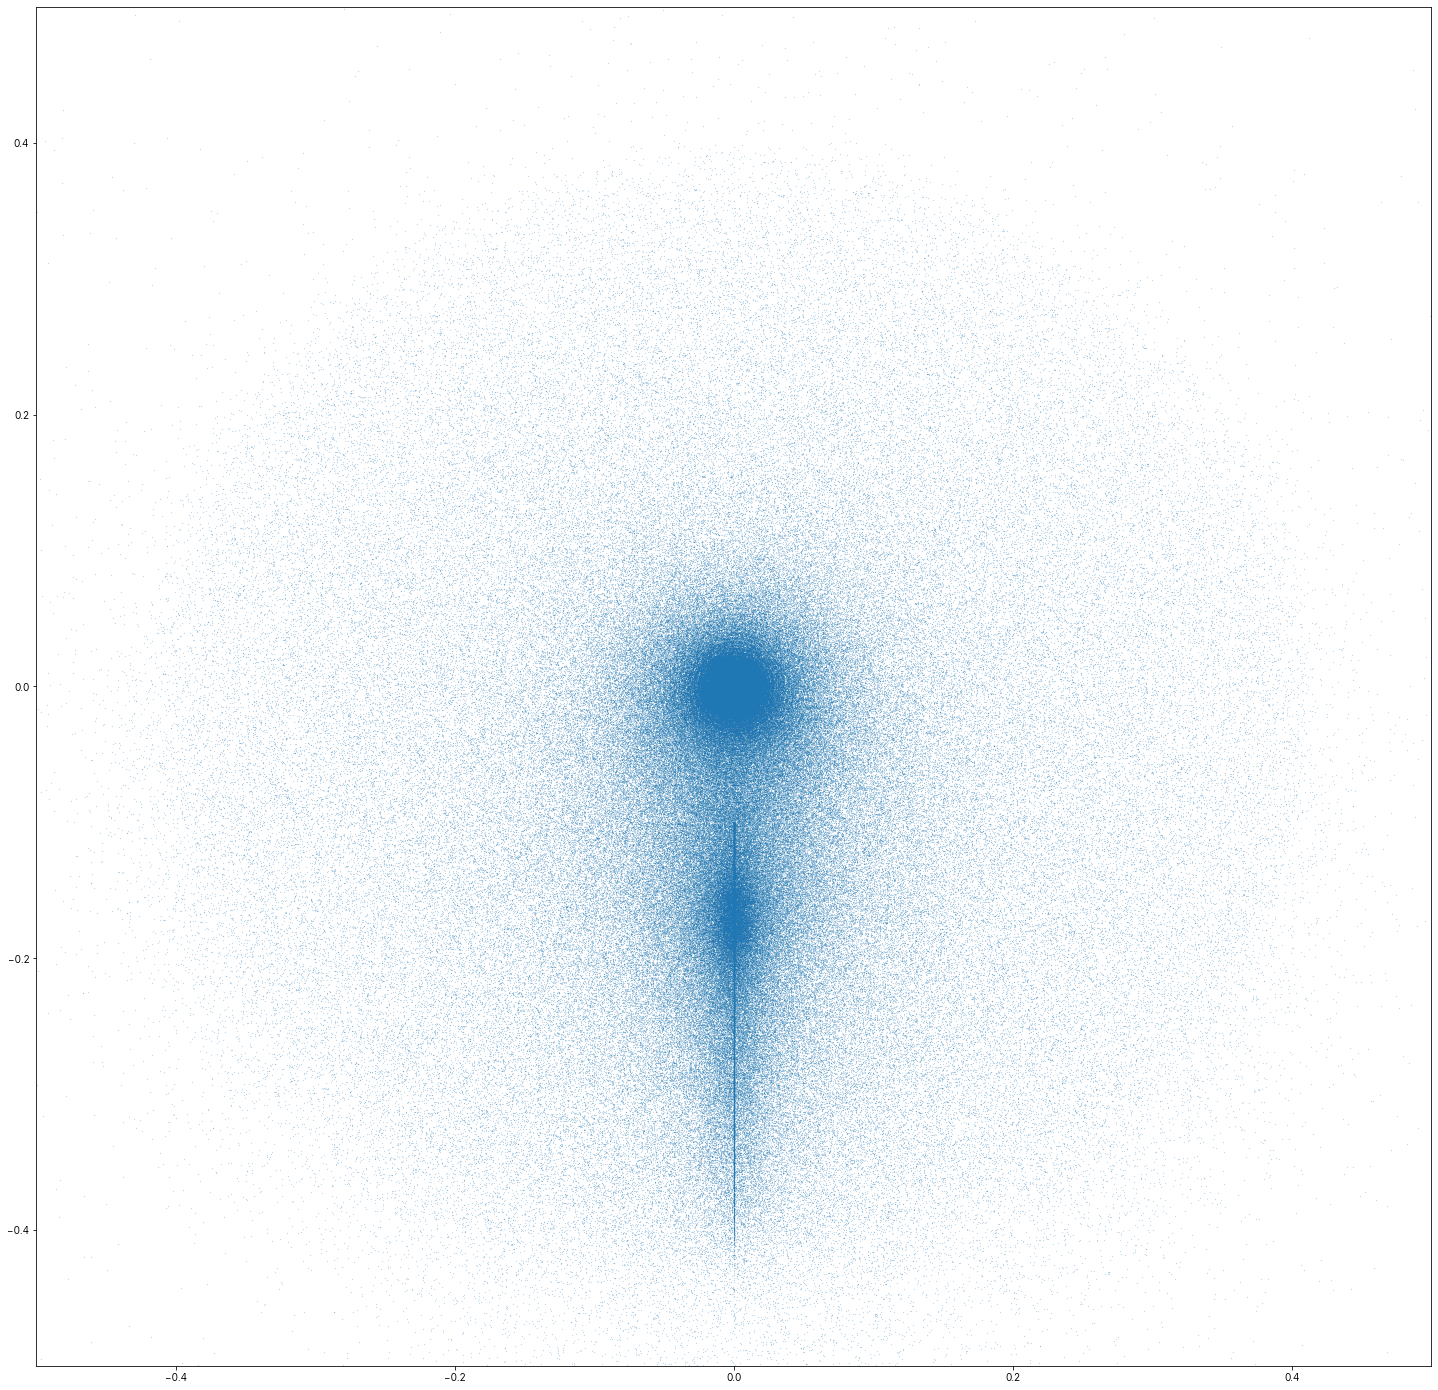

In [446]:
plt.figure(figsize=(25, 25))

# plt.scatter(x=X_stack[:, 1], y=X_stack[:, 2], s=1e-3);
# plt.scatter(x=X_stack[:, 1], y=X_stack[:, 2], s=0.0000042059);
plt.scatter(x=X_stack[:, 1], y=X_stack[:, 2], s=1e-2);

bound = 0.5
plt.xlim((-bound, bound))
plt.ylim((-bound, bound))